# Minhashing
Answers the question, "how similar is this document to that document?"

More concretely, it's a probabilistic estimate for comparing sets of documents using [jaccard similarity](nformation-theory/jaccard_similarity.ipynb). It creates `signatures` for each `set` in such a way that similar documents, will have similar `signatures`.

### steps:
<strong>1)</strong> breaks down a document into shingles<br>
<strong>2)</strong> calculates a [hash](../hash_function.ipynb) value for every shingle<br>
<strong>3)</strong> stores the `minimum` hash value<br>
<strong>4)</strong> repeats `2` and `3` with a new hash function for another X times<br>

In [448]:
import collections

s1 = "the quick brown fox jumps over the lazy dog"
s2 = "the quick brown cow jumps over the lazy dog"

def jaccard(string_a, string_b):
    sa, sb = set(string_a), set(string_b)
    return len(sa & sb) / len(sa | sb)

def shingles(s, size=2): 
    s_ = s.split(" ")
    return [ s_[i:i+size] for i in range(len(s_)-size)]

n = 2
documents = [s1, s2]

shingle_dict = collections.defaultdict(int)

def create_shingles(doc, shingle_dict, size=2):
    
    key = len(shingle_dict.keys())
    tokens = doc.split(" ")
    res = []
    
    for i in range(len(tokens) - size):
        
        t = tokens[i: i+size]
        
        t_str = " ".join(t)
        if not t_str in shingle_dict:
            shingle_dict[t_str] = key
            key += 1
            
        res.append(t)
        
    return res, shingle_dict

document_shingles = []
for doc in documents:
    shingles, shingle_dict = create_shingles(doc, shingle_dict, n)
    document_shingles.append(shingles)
    
print(shingle_dict)

defaultdict(<class 'int'>, {'the quick': 0, 'quick brown': 1, 'brown fox': 2, 'fox jumps': 3, 'jumps over': 4, 'over the': 5, 'the lazy': 6, 'brown cow': 7, 'cow jumps': 8})


If we look at the original strings, and only use `unigrams` we find that the `jaccard similarity` to be:

In [449]:
print(f"jaccard similarity: {jaccard(s1, s2): 0.2f}")

jaccard similarity:  0.93


If we do it on `bigrams` we get:

In [450]:
a, b = [set([" ".join(x) for x in document]) for document in document_shingles]

print(f"jaccard similarity: {len(a & b) /  len(a | b): 0.2f}")

jaccard similarity:  0.56


#### Build a characteristics matrix
For this to work, we first build a sparse matrix representation ($m_{I\times J}$) of our sets, where the rows represent every possible element/shingle/thing, and the columns represent each set. The element in the matrix are binary values indicating whether element $i$ is in set $j$. 

In [451]:
# v = shingle_dict.values()
tup = sorted([(x, shingle_dict[x]) for x in shingle_dict.keys() if type(x) == str], key=lambda x: x[1])
k = list(map(lambda x: x[0], tup))
v = list(map(lambda x: x[1], tup))

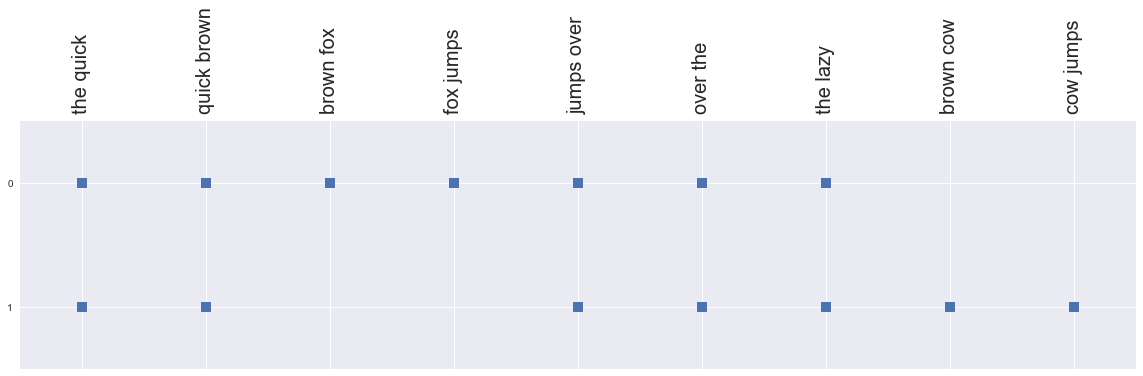

In [452]:
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
plt.style.use("seaborn")

characteristic = sp.sparse.lil_matrix((len(shingle_dict.keys()), len(documents)), dtype=np.int16)
for j, document in enumerate(document_shingles):
    for shingle in document:
        shingle_str = " ".join(shingle)
        i = shingle_dict[shingle_str]
        characteristic[i, j] = 1

tup = sorted([(x, shingle_dict[x]) for x in shingle_dict.keys() if type(x) == str], key=lambda x: x[1])
k = list(map(lambda x: x[0], tup))
v = list(map(lambda x: x[1], tup))

x_ticks = list(shingle_dict)
# this is an inverted view of the matrix
fig = plt.figure(figsize=(20, 12))
plt.spy(characteristic.T)
plt.xticks(v, k, rotation=90, fontsize=20);

#### Estimating the jaccard
We can estimate the `jaccard similarity` by permuting the rows of the `characteristic matrix`. 

In [498]:
%%time
res, n = [], 500
permuted_rows = np.arange(characteristic.shape[0])

for _ in range(n):
    np.random.shuffle(permuted_rows)
    arr = characteristic[permuted_rows, :]
    indices = np.argmax(arr.toarray(), axis=0)
    res.append(indices[0] == indices[1])
    
print(f"jaccard estimate: {np.sum(res) / n:0.2f} with {n} iterations")

jaccard estimate: 0.55 with 500 iterations
CPU times: user 65.7 ms, sys: 3.22 ms, total: 68.9 ms
Wall time: 66.4 ms


Unfortunately, shuffling a list of indices is inneficient, so we're going to perform a little trick. This is when `minhash` comes into play.

Some `minhash function` $h(C)$ = the number of the first (in the permuted order) row in which column C has 1.

Start by generating $k$ random hash functions

In [490]:
import hashlib

n_hash_funcs = 100
hash_funcs = []

n_keys = len(shingle_dict.keys()) # should actually be a prime number
for _ in range(n_hash_funcs):
    f = lambda x: (np.random.randint(0, n_keys) * x + np.random.randint(0, n_keys)) % n_keys
    hash_funcs.append(f)

this approach doesn't work very well

In [494]:
%%time 

signature_matrix = np.zeros((n_hash_funcs, characteristic.shape[1]))
signature_matrix[:] = np.inf

for c in range(characteristic.shape[1]):
    for i in range(characteristic.shape[0]):
        if characteristic[i, c] == 1:
            for j in range(n_hash_funcs):
                f = hash_funcs[j]
                h = f(i)
                counters[j, c] = min(h, signature_matrix[j, c])
                    
print(f"jaccard estiamte: {np.sum(counters[:, 0] == counters[:, 1]) / n_hash_funcs}")

jaccard estiamte: 0.11
CPU times: user 7.42 ms, sys: 275 µs, total: 7.7 ms
Wall time: 7.51 ms


In [491]:
%%time 

### minhashing
# each minhashin hash function is associated with a permutation of the row indices — just imagie
# h(c) = the number of the first row (in permuted order) in which column C is 1
# use several independent hash functions to create a signature for each column (100 or 200)
# the signatures can be displayed in another matrix — the signature matrix — in which the columns represent the
# sets and the rows represent the minhash values, in order for that column

signature_matrix = np.zeros((n_hash_funcs, characteristic.shape[1]))
signature_matrix[:] = np.inf

n_rows, n_cols = characteristic.shape
rows = np.arange(n_rows)

for j, f in enumerate(hash_funcs):
    permuted_rows = map(f, rows)
    print(list(permuted_rows))
    for i, idx in enumerate(permuted_rows): # iterate over the permuted rows
        for c in range(n_cols): 
            if characteristic[idx, c] == 1:
                signature_matrix[j, c] = i
                continue
                
print(f"jaccard estiamte: {np.sum(counters[:, 0] == counters[:, 1]) / n_hash_funcs}")

[0, 0, 2, 3, 1, 5, 1, 3, 7]
[0, 1, 7, 0, 7, 4, 4, 8, 7]
[4, 3, 7, 8, 3, 1, 2, 2, 7]
[3, 1, 6, 3, 4, 0, 1, 3, 7]
[6, 7, 7, 2, 8, 5, 3, 6, 8]
[8, 4, 3, 2, 1, 4, 3, 5, 8]
[8, 4, 1, 4, 3, 3, 8, 8, 1]
[4, 6, 4, 6, 6, 3, 7, 7, 8]
[2, 2, 3, 5, 1, 5, 8, 5, 7]
[0, 2, 7, 6, 2, 6, 1, 2, 0]
[7, 6, 1, 7, 2, 6, 2, 7, 2]
[6, 3, 2, 7, 3, 5, 1, 3, 0]
[3, 8, 0, 4, 5, 6, 5, 8, 5]
[1, 1, 4, 8, 8, 1, 0, 0, 6]
[4, 7, 8, 4, 2, 4, 5, 4, 2]
[3, 7, 8, 6, 1, 3, 6, 5, 2]
[0, 6, 0, 1, 6, 4, 8, 3, 6]
[1, 7, 4, 2, 6, 6, 0, 4, 8]
[2, 5, 6, 3, 4, 5, 6, 4, 4]
[1, 8, 3, 3, 5, 7, 4, 2, 5]
[4, 4, 6, 5, 7, 2, 5, 6, 3]
[7, 4, 1, 5, 5, 8, 4, 6, 5]
[6, 5, 6, 7, 4, 5, 8, 8, 3]
[6, 5, 1, 6, 2, 5, 5, 3, 0]
[1, 0, 7, 0, 7, 5, 6, 4, 7]
[8, 5, 0, 5, 7, 1, 2, 3, 6]
[6, 2, 4, 4, 7, 0, 7, 2, 3]
[7, 0, 8, 1, 0, 3, 8, 1, 1]
[4, 3, 0, 4, 8, 7, 0, 7, 2]
[4, 1, 0, 1, 7, 5, 8, 0, 7]
[5, 6, 7, 1, 7, 3, 8, 4, 3]
[6, 0, 1, 3, 1, 0, 2, 7, 0]
[5, 1, 4, 4, 4, 2, 1, 7, 5]
[4, 6, 7, 2, 7, 0, 0, 4, 4]
[6, 3, 3, 5, 0, 2, 6, 1, 3]
[4, 7, 3, 6, 4, 7, 3

### Resources:
* [Mining Massing Datasets - Chapter 3 Finding Similar Items](http://mmds.org/)
* [Minhash tutorial](http://mccormickml.com/2015/06/12/minhash-tutorial-with-python-code/)
* [Minhashing for dummies](https://matthewcasperson.blogspot.com/2013/11/minhash-for-dummies.html)